In [2]:
import warnings
from io import BytesIO
from pathlib import Path
from urllib.parse import urlparse
from urllib.request import urlopen, urlretrieve
from zipfile import ZipFile, is_zipfile
import os

import pandas as pd
import socceraction.vaep.features as features
import socceraction.vaep.labels as labels

from sklearn.metrics import brier_score_loss, roc_auc_score, log_loss
from socceraction.spadl.wyscout import convert_to_actions
from socceraction.vaep.formula import value
import socceraction.vaep.formula as vaepformula
from tqdm.notebook import tqdm
from xgboost import XGBClassifier as XGBc
import tqdm
import random

import socceraction.atomic.spadl as atomicspadl
import socceraction.atomic.vaep.features as fs
import socceraction.atomic.vaep.labels as lab

import socceraction.atomic.spadl as atomicspadl
import socceraction.atomic.vaep.formula as vaepformula

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as logistic
from sklearn.ensemble import RandomForestClassifier as rfc
from catboost import CatBoostClassifier 
#warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)

%load_ext autoreload
%autoreload 2
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl
import socceraction.atomic.spadl as atomicspadl
from socceraction.data.wyscout import PublicWyscoutLoader

In [3]:
wyscout = PublicWyscoutLoader(root = '/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/data', download=False)

In [5]:
competitions = wyscout.competitions()
competitions.info()

<class 'pandera.typing.pandas.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   competition_id      7 non-null      int64 
 1   season_id           7 non-null      int64 
 2   country_name        7 non-null      object
 3   competition_name    7 non-null      object
 4   competition_gender  7 non-null      object
 5   season_name         7 non-null      object
dtypes: int64(2), object(4)
memory usage: 464.0+ bytes


In [8]:
#Select competitions
comp = ['European_Championship', 'World_Cup']
#Info about selected competitions
selected_competitions = competitions[(competitions['country_name'] =='International')]
selected_competitions

,competition_id,season_id,country_name,competition_name,competition_gender,season_name
5,102,9291,International,European Championship,male,2016
6,28,10078,International,World Cup,male,2018


### Retrieve the scoreline of a game

In [20]:
dfs_matches = []
#Retrieve matches of a selected competition
for competition in comp:
    competition_name = competition
    file_matches = f'matches_{competition_name}.json'
    df_matches = pd.read_json('/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/Data/' + file_matches)
    dfs_matches.append(df_matches)
    
#Create a unique dataframe containing all the selected games
df_matches = pd.concat(dfs_matches)
df_matches.reset_index(drop = True, inplace = True)
df_matches.head()

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,groupName,referees,duration,competitionId
0,Played,4165474,0,"{'9905': {'scoreET': 1, 'coachId': 137521, 'si...",9291,2016-07-10 19:00:00,9905,Stade de France,1694440,"Portugal - France, 1 - 0 (E)",2016-07-10 21:00:00-02:00,Group F,"[{'refereeId': 381617, 'role': 'referee'}, {'r...",ExtraTime,102
1,Played,4165473,0,"{'3148': {'scoreET': 0, 'coachId': 134365, 'si...",9291,2016-07-07 19:00:00,4418,Stade V\u00e9lodrome,1694439,"Germany - France, 0 - 2",2016-07-07 21:00:00-02:00,Group F,"[{'refereeId': 377209, 'role': 'referee'}, {'r...",Regular,102
2,Played,4165473,0,"{'10682': {'scoreET': 0, 'coachId': 136439, 's...",9291,2016-07-06 19:00:00,9905,Groupama Stadium,1694438,"Portugal - Wales, 2 - 0",2016-07-06 21:00:00-02:00,Group F,"[{'refereeId': 384373, 'role': 'referee'}, {'r...",Regular,102
3,Played,4165472,0,"{'7839': {'scoreET': 0, 'coachId': 210205, 'si...",9291,2016-07-03 19:00:00,4418,Stade de France,1694437,"France - Iceland, 5 - 2",2016-07-03 21:00:00-02:00,Group F,"[{'refereeId': 377215, 'role': 'referee'}, {'r...",Regular,102
4,Played,4165472,0,"{'3148': {'scoreET': 1, 'coachId': 134365, 'si...",9291,2016-07-02 19:00:00,3148,Stade Matmut-Atlantique,1694436,"Germany - Italy, 1 - 1 (P)",2016-07-02 21:00:00-02:00,Group F,"[{'refereeId': 383185, 'role': 'referee'}, {'r...",Penalties,102


In [21]:
#Extrapolate the scoreline of the game 
home_score, away_score = [],[]
for i in range(len(df_matches)) : 
    home_id, away_id = df_matches['teamsData'][i].keys()
    if df_matches['teamsData'][i][home_id]['side'] == 'away':
        home_id, away_id = away_id, home_id
    if df_matches['duration'][i] !='Regular':
        home_score.append(df_matches['teamsData'][i][home_id]['scoreET'])
        away_score.append(df_matches['teamsData'][i][away_id]['scoreET'])
    else:    
        home_score.append(df_matches['teamsData'][i][home_id]['score']+df_matches['teamsData'][i][home_id]['scoreET'])
        away_score.append(df_matches['teamsData'][i][away_id]['score']+df_matches['teamsData'][i][away_id]['scoreET'])

df_matches['home_score'] = home_score
df_matches['away_score'] = away_score
df_matches = df_matches[['seasonId','wyId','label','competitionId', 'home_score','away_score']]
df_matches.rename(columns={'seasonId':'season_id', 'wyId':'game_id','competitionId':'competition_id'}, inplace = True)

df_matches.head()

,season_id,game_id,label,competition_id,home_score,away_score
0,9291,1694440,"Portugal - France, 1 - 0 (E)",102,1,0
1,9291,1694439,"Germany - France, 0 - 2",102,0,2
2,9291,1694438,"Portugal - Wales, 2 - 0",102,2,0
3,9291,1694437,"France - Iceland, 5 - 2",102,5,2
4,9291,1694436,"Germany - Italy, 1 - 1 (P)",102,1,1


In [23]:
# Get games from all selected competitions
games = pd.concat([wyscout.games(row.competition_id, row.season_id) for row in selected_competitions.itertuples()])
games

,game_id,competition_id,season_id,game_date,game_day,home_team_id,away_team_id
0,1694440,102,9291,2016-07-10 19:00:00,0,9905,4418
1,1694439,102,9291,2016-07-07 19:00:00,0,3148,4418
2,1694438,102,9291,2016-07-06 19:00:00,0,9905,10682
3,1694437,102,9291,2016-07-03 19:00:00,0,4418,7839
4,1694436,102,9291,2016-07-02 19:00:00,0,3148,3757
...,...,...,...,...,...,...,...
59,2057966,28,10078,2018-06-16 10:00:00,1,4418,8493
60,2057960,28,10078,2018-06-15 18:00:00,1,9905,1598
61,2057961,28,10078,2018-06-15 15:00:00,1,16216,10840
62,2057955,28,10078,2018-06-15 12:00:00,1,16129,15670


In [113]:
match_goals = pd.merge(games, df_matches, on =['game_id','competition_id','season_id'])
match_goals.drop(['label'],axis = 1, inplace = True)
games = match_goals

In [114]:
games[["home_team_id", "away_team_id", "game_date","home_score", "away_score"]]

,home_team_id,away_team_id,game_date,home_score,away_score
0,9905,4418,2016-07-10 19:00:00,1,0
1,3148,4418,2016-07-07 19:00:00,0,2
2,9905,10682,2016-07-06 19:00:00,2,0
3,4418,7839,2016-07-03 19:00:00,5,2
4,3148,3757,2016-07-02 19:00:00,1,1
...,...,...,...,...,...
110,4418,8493,2018-06-16 10:00:00,2,1
111,9905,1598,2018-06-15 18:00:00,3,3
112,16216,10840,2018-06-15 15:00:00,0,1
113,16129,15670,2018-06-15 12:00:00,0,1


In [115]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115 entries, 0 to 114
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   game_id         115 non-null    int64         
 1   competition_id  115 non-null    int64         
 2   season_id       115 non-null    int64         
 3   game_date       115 non-null    datetime64[ns]
 4   game_day        115 non-null    int64         
 5   home_team_id    115 non-null    int64         
 6   away_team_id    115 non-null    int64         
 7   home_score      115 non-null    int64         
 8   away_score      115 non-null    int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 9.0 KB


### Convert event to actions

# DO NOT RUN

In [116]:
#Store everything in the HDF
datafolder = "/Users/leonardoyang/Desktop/data-fifa/training"

In [117]:
#To upload the DF
spadl_h5 = os.path.join(datafolder, "atomic_spadl-wyscout.h5")

In [118]:
pd.HDFStore(spadl_h5)['teams'].reset_index().drop('index', axis =1)

,team_id,team_name_short,team_name
0,9905,Portugal,Portugal
1,4418,France,France
2,3148,Germany,Germany
3,10682,Wales,Wales
4,7839,Iceland,Iceland
5,3757,Italy,Italy
6,5629,Belgium,Belgium
7,13869,Poland,Poland
8,2413,England,England
9,1598,Spain,Spain


#### For plot

In [22]:
c = 0
for game in games.game_id:
    atomic_actions = pd.HDFStore(spadl_h5)[f"actions/game_{game}"]
    c+=len(atomic_actions)

In [23]:
c/115

2253.7391304347825

In [29]:
euro = games[games.competition_id == 102]
wc = games[games.competition_id == 28]

In [30]:
all_games = pd.DataFrame()
for game in tqdm.tqdm(euro.game_id, desc="Loading actions"):
    actions = atomicspadl.add_names(pd.HDFStore(spadl_h5) [f"actions/game_{game}"])[['type_name','bodypart_name']]
    actions['League'] = 'Euro 2016'
    all_games = all_games.append(actions)
for game in tqdm.tqdm(wc.game_id, desc="Loading actions"):
    actions = atomicspadl.add_names(pd.HDFStore(spadl_h5) [f"actions/game_{game}"])[['type_name','bodypart_name']]
    actions['League'] = 'World Cup 2018'
    all_games = all_games.append(actions)

Loading actions:   0%|          | 0/51 [00:00<?, ?it/s]/var/folders/wj/rf_7mtyj4mz92p07_kctx9t80000gn/T/ipykernel_1026/1223103352.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions['League'] = 'Euro 2016'
Loading actions:   0%|          | 0/64 [00:00<?, ?it/s]/var/folders/wj/rf_7mtyj4mz92p07_kctx9t80000gn/T/ipykernel_1026/1223103352.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions['League'] = 'World Cup 2018'
Loading actions: 100%|██████████| 64/64 [00:02<00:00, 21.36it/s]


In [32]:
all_games

,type_name,bodypart_name,League
0,pass,foot,Euro 2016
1,receival,foot,Euro 2016
2,pass,foot,Euro 2016
3,receival,foot,Euro 2016
4,pass,foot,Euro 2016
...,...,...,...
2198,tackle,foot,World Cup 2018
2199,foul,foot,World Cup 2018
2200,freekick,foot,World Cup 2018
2201,goal,foot,World Cup 2018


In [33]:
all_games = all_games.groupby(['League','type_name']).count().rename(columns = {'bodypart_name':'Count'}).reset_index().sort_values('Count', ascending = False)

In [34]:
sns.set_style('whitegrid')
fig, axs = plt.subplots(figsize = (26,7))
sns.barplot(data = all_games, x = all_games.type_name, y = all_games.Count, hue = 'League')
plt.xlabel('Action', fontsize = 15)
plt.ylabel('Count',fontsize = 15)
plt.xticks(fontsize = 13)
plt.legend(fontsize= 14)
plt.yticks(fontsize = 14)

NameError: name 'sns' is not defined

### Training 

In [119]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    # Select England vs Belgium game at World Cup
    game = games[(games.home_team_name_short == "Portugal") & (games.away_team_name_short== "France")]
    game_id = game.game_id.values[0]
    atomic_actions = spadlstore[f"actions/game_{game_id}"]
    atomic_actions = (
        atomic_actions
        .merge(atomicspadl.actiontypes_df(), how="left")
        .merge(spadl.bodyparts_df(), how="left")
        .merge(spadlstore["players"], how="left")
        .merge(spadlstore["teams"], how="left")
    )

# use nickname if available else use full name
atomic_actions["player_name"] = atomic_actions[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
del atomic_actions['nickname']
atomic_actions[2930:2940]

,game_id,original_event_id,action_id,period_id,time_seconds,team_id,player_id,x,y,dx,dy,type_id,bodypart_id,type_name,bodypart_name,player_name,team_name_short,team_name
2930,1694440,90589250,2930,4,198.490595,9905,32597,73.50,57.12,0.00,0.00,23,0,receival,foot,Ricardo Quaresma,Portugal,Portugal
2931,1694440,90589251,2931,4,199.000679,9905,32597,73.50,57.12,-3.15,-2.04,0,0,pass,foot,Ricardo Quaresma,Portugal,Portugal
2932,1694440,90589251,2932,4,199.548856,9905,70093,70.35,55.08,0.00,0.00,23,0,receival,foot,João Moutinho,Portugal,Portugal
2933,1694440,90589252,2933,4,200.097033,9905,70093,70.35,55.08,11.55,-8.84,0,0,pass,foot,João Moutinho,Portugal,Portugal
2934,1694440,90589252,2934,4,201.179747,9905,70410,81.90,46.24,0.00,0.00,23,0,receival,foot,Éder,Portugal,Portugal
2935,1694440,NaN,2935,4,202.262461,9905,70410,81.90,46.24,-1.05,-9.52,21,0,dribble,foot,Éder,Portugal,Portugal
2936,1694440,90589254,2936,4,204.427888,9905,70410,80.85,36.72,24.15,0.68,11,0,shot,foot,Éder,Portugal,Portugal
2937,1694440,90589254,2937,4,204.427888,9905,70410,105.00,37.40,0.00,0.00,27,0,goal,foot,Éder,Portugal,Portugal
2938,1694440,90589255,2938,4,284.787972,9905,28907,36.75,62.56,4.20,5.44,18,0,clearance,foot,Raphaël Guerreiro,Portugal,Portugal
2939,1694440,90589255,2939,4,287.829754,9905,28907,40.95,68.00,0.00,0.00,25,0,out,foot,Raphaël Guerreiro,Portugal,Portugal


In [120]:
#Eder riceve, dribla, tira e fa goal.

2016-07-10 19:00:00, Portugal - France : 1-0 , Éder 139'


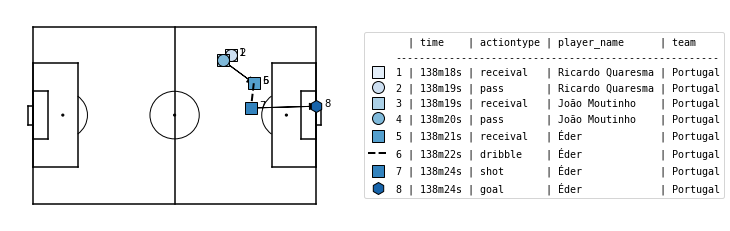

In [47]:
#select a goal to plot
import matplotsoccer

for shot in list(atomic_actions[(atomic_actions.type_name == "goal")].index):
    a = atomic_actions[shot-7:shot+1].copy()

    a["start_x"] = a.x
    a["start_y"] = a.y
    a["end_x"] = a.x + a.dx
    a["end_y"] = a.y + a.dy

    g = game.iloc[0]
    minute = int((a.period_id.values[0] - 1) * 45 + a.time_seconds.values[0] // 60)
    game_info = f"{g.game_date}, {g.home_team_name} - {g.away_team_name} : {g.home_score}-{g.away_score} , {a[-1:].player_name.values[0]} {minute + 1}'"
    print(game_info)

    def nice_time(row):
        minute = int((row.period_id-1) * 45 + row.time_seconds // 60)
        second = int(row.time_seconds % 60)
        return f"{minute}m{second}s"

    a["nice_time"] = a.apply(nice_time,axis=1)
    labels = a[["nice_time", "type_name", "player_name", "team_name"]]

    matplotsoccer.actions(
        location=a[["start_x", "start_y", "end_x", "end_y"]],
        action_type=a.type_name,
        team= a.team_name,
        label=labels,
        labeltitle=["time", "actiontype", "player_name", "team"],
        zoom=False,
        figsize=6
    )

In [48]:
df_players = pd.read_json('/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/players.json')
df_players = df_players[['wyId','shortName','role']]

Role = []
for i in range(len(df_players)):
    Role.append(df_players['role'][i]['name'])

df_players['Role'] = Role
df_players.drop('role', axis = 1,inplace = True)

## Compute features and labels

In [49]:
features_h5 = os.path.join(datafolder, "atomic_features.h5")
labels_h5 = os.path.join(datafolder, "atomic_labels.h5")

In [50]:
games = pd.HDFStore(spadl_h5)['games']
print("nb of games:", len(games))
#Features di TUTTE le partite

nb of games: 115


In [70]:
games

,game_id,competition_id,season_id,game_date,game_day,home_team_id,away_team_id,home_score,away_score
0,1694440,102,9291,2016-07-10 19:00:00,0,9905,4418,1,0
1,1694439,102,9291,2016-07-07 19:00:00,0,3148,4418,0,2
2,1694438,102,9291,2016-07-06 19:00:00,0,9905,10682,2,0
3,1694437,102,9291,2016-07-03 19:00:00,0,4418,7839,5,2
4,1694436,102,9291,2016-07-02 19:00:00,0,3148,3757,1,1
...,...,...,...,...,...,...,...,...,...
110,2057966,28,10078,2018-06-16 10:00:00,1,4418,8493,2,1
111,2057960,28,10078,2018-06-15 18:00:00,1,9905,1598,3,3
112,2057961,28,10078,2018-06-15 15:00:00,1,16216,10840,0,1
113,2057955,28,10078,2018-06-15 12:00:00,1,16129,15670,0,1


In [65]:
#features
xfns = [
    fs.actiontype,
    fs.actiontype_onehot,
    fs.bodypart,
    fs.bodypart_onehot,
    fs.goalscore,
    fs.location,
    fs.polar,
    fs.direction,
    fs.team,
    fs.time,
    fs.time_delta
]

with pd.HDFStore(spadl_h5) as spadlstore, pd.HDFStore(features_h5) as featurestore:
    for game in tqdm.tqdm(list(games.itertuples()),desc=f"Generating and storing features in {features_h5}"):
        actions = spadlstore[f"actions/game_{game.game_id}"] #prende azioni di ogni partita
        gamestates = fs.gamestates(atomicspadl.add_names(actions), 3) # prende azioni, considera le 3 precedenti. #Crea partite con i lag di ogni azioni(-1,-2).
        gamestates = fs.play_left_to_right(gamestates, game.home_team_id)

        X = pd.concat([fn(gamestates) for fn in xfns], axis=1) # le 3 partite vengono unite
        featurestore[f"game_{game.game_id}"] = X

Generating and storing features in /Users/leonardoyang/Desktop/data-fifa/training/atomic_features.h5: 100%|██████████| 115/115 [00:20<00:00,  5.67it/s]


In [81]:
pd.HDFStore(spadl_h5)["actions/game_2057954"].head()

,game_id,original_event_id,action_id,period_id,time_seconds,team_id,player_id,x,y,dx,dy,type_id,bodypart_id
0,2057954,258612104,0,1,1.656214,16521,122671,52.50,34.00,15.75,2.04,0,0
1,2057954,258612104,1,1,3.072014,16521,139393,68.25,36.04,0.00,0.00,23,0
2,2057954,258612106,2,1,4.487814,16521,139393,68.25,36.04,-42.00,-23.12,0,0
3,2057954,258612106,3,1,5.506402,16521,122847,26.25,12.92,0.00,0.00,23,0
4,2057954,NaN,4,1,6.524990,16521,122847,26.25,12.92,12.60,-1.36,21,0


In [82]:
pd.HDFStore(features_h5)["game_2057954"].head() #Con i lag 0,-1,-2.

,type_id_a0,type_id_a1,type_id_a2,type_pass_a0,type_cross_a0,type_throw_in_a0,type_freekick_crossed_a0,type_freekick_short_a0,type_corner_crossed_a0,type_corner_short_a0,...,time_seconds_a0,time_seconds_overall_a0,period_id_a1,time_seconds_a1,time_seconds_overall_a1,period_id_a2,time_seconds_a2,time_seconds_overall_a2,time_delta_1,time_delta_2
0,0,0,0,True,False,False,False,False,False,False,...,1.656214,1.656214,1,1.656214,1.656214,1,1.656214,1.656214,0.000000,0.000000
1,23,0,0,False,False,False,False,False,False,False,...,3.072014,3.072014,1,1.656214,1.656214,1,1.656214,1.656214,1.415800,1.415800
2,0,23,0,True,False,False,False,False,False,False,...,4.487814,4.487814,1,3.072014,3.072014,1,1.656214,1.656214,1.415800,2.831600
3,23,0,23,False,False,False,False,False,False,False,...,5.506402,5.506402,1,4.487814,4.487814,1,3.072014,3.072014,1.018588,2.434388
4,21,23,0,False,False,False,False,False,False,False,...,6.524990,6.524990,1,5.506402,5.506402,1,4.487814,4.487814,1.018588,2.037176


In [83]:
#labels
yfns = [lab.scores, lab.concedes, lab.goal_from_shot]

with pd.HDFStore(spadl_h5) as spadlstore, pd.HDFStore(labels_h5) as labelstore:
    for game in tqdm.tqdm(list(games.itertuples()), desc=f"Computing and storing labels in {labels_h5}"):
        actions = spadlstore[f"actions/game_{game.game_id}"]
        Y = pd.concat([fn(atomicspadl.add_names(actions)) for fn in yfns], axis=1)
        labelstore[f"game_{game.game_id}"] = Y


Computing and storing labels in /Users/leonardoyang/Desktop/data-fifa/training/atomic_labels.h5: 100%|██████████| 115/115 [00:15<00:00,  7.19it/s]


In [87]:
pd.HDFStore(labels_h5)["game_2057954"].head(10) #Con i lag 0,-1,-2.

,scores,concedes,goal
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
5,False,False,False
6,False,False,False
7,False,False,False
8,False,False,False
9,False,False,False


In [28]:
#Labels
#goal = True if goal from a shot. Non mi sembra venga usato dopo
#Score = True if within next 10 actions goal
#concedes = True if within next 10 actions goal
#Chi ha palla è score, se durante azione c'è qualche intervento avversario c'è concedes = true.
#Goal è true solo se shot, score e concedes ci sono comunque.

### Compute Probabilities

In [53]:
predictions_h5 = os.path.join(datafolder, "atomic-predictions-one-action.h5")

In [60]:
traingames, testgames = train_test_split(games, test_size=0.3, random_state=42, shuffle=True)
traingames

,game_id,competition_id,season_id,game_date,game_day,home_team_id,away_team_id,home_score,away_score
33,1694405,102,9291,2016-06-16 19:00:00,2,3148,13869,0,0
62,2058006,28,10078,2018-07-02 14:00:00,0,6380,15473,2,0
65,2058002,28,10078,2018-06-30 18:00:00,0,15670,9905,2,1
28,1694422,102,9291,2016-06-18 16:00:00,2,7839,10451,1,1
42,1694414,102,9291,2016-06-13 16:00:00,1,8274,7047,1,1
...,...,...,...,...,...,...,...,...,...
106,2057979,28,10078,2018-06-17 12:00:00,1,16871,17322,0,1
14,1694426,102,9291,2016-06-25 13:00:00,0,6697,13869,1,1
92,2057974,28,10078,2018-06-21 18:00:00,2,12274,9598,0,3
51,2058017,28,10078,2018-07-15 15:00:00,0,4418,9598,4,2


In [88]:
# 1. Select feature set X
xfns = [
    #fs.actiontype,
    fs.actiontype_onehot,
    #fs.bodypart,
    fs.bodypart_onehot,
    fs.goalscore,
    fs.location,
    fs.polar,
    fs.direction,
    fs.team,
    fs.time,
    fs.time_delta
]
nb_prev_actions = 3

Xcols = fs.feature_column_names(xfns, nb_prev_actions)

def getXY(games, Xcols):
    # generate the columns of the selected feature
    X = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting features"): #aggiungi azioni di ogni partita
        Xi = pd.HDFStore(features_h5) [f"game_{game_id}"]
        X.append(Xi[Xcols])
    X = pd.concat(X).reset_index(drop=True)

    # 2. Select label Y
    Ycols = ["scores", "concedes"]
    Y = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting label"):
        Yi = pd.HDFStore(labels_h5)[f"game_{game_id}"]
        Y.append(Yi[Ycols])
    Y = pd.concat(Y).reset_index(drop=True)
    return X, Y

In [89]:
X,Y = getXY(traingames, Xcols)
#print("X:", list(X.columns))
#print("Y:", list(Y.columns))
X = X.fillna(0)

Selecting label: 100%|██████████| 80/80 [00:00<00:00, 120.55it/s]


In [ ]:
#Prendiamo le features e labels del train.

In [98]:
#'goalscore_team','goalscore_opponent' = goal segnati fin'ora dalla squadra che fa l'ultima azione.

## Train 

In [57]:
%%time
# 3. train classifiers F(X) = Y

Y_hat = pd.DataFrame()
models = {}
for col in list(Y.columns):
    model = logistic(random_state = 42)
    model.fit(X, Y[col])
    models[col] = model

/Users/leonardoyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CPU times: user 17.1 s, sys: 918 ms, total: 18 s
Wall time: 11.5 s


/Users/leonardoyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [58]:
for col in testY.columns:
    Y_hat[col] = [p[1] for p in models[col].predict_proba(testX)] #[1] = prob del True
    print(f"### Y: {col} ###")
    evaluate(testY[col], Y_hat[col])

### Y: scores ###
  Brier score: 0.00757 (0.92328)
  log loss score: 0.03880 (0.81046)
  ROC AUC: 0.83922
### Y: concedes ###
  Brier score: 0.00194 (0.96406)
  log loss score: 0.01310 (0.90059)
  ROC AUC: 0.75147


In [55]:
%%time
# 3. train classifiers F(X) = Y

Y_hat = pd.DataFrame()
models = {}
for col in list(Y.columns):
    model = XGBc(n_estimators=100, max_depth=5,random_state = 42)
    model.fit(X, Y[col])
    models[col] = model

CPU times: user 8min 49s, sys: 4.75 s, total: 8min 53s
Wall time: 3min 40s


In [56]:
for col in testY.columns:
    Y_hat[col] = [p[1] for p in models[col].predict_proba(testX)] #[1] = prob del True
    print(f"### Y: {col} ###")
    evaluate(testY[col], Y_hat[col])

### Y: scores ###
  Brier score: 0.00791 (0.96437)
  log loss score: 0.04042 (0.84434)
  ROC AUC: 0.83347
### Y: concedes ###
  Brier score: 0.00246 (1.21965)
  log loss score: 0.01367 (0.93914)
  ROC AUC: 0.85607


In [53]:
%%time
# 3. train classifiers F(X) = Y

Y_hat = pd.DataFrame()
models = {}
for col in list(Y.columns):
    model = rfc(n_estimators=100, random_state = 42)
    model.fit(X, Y[col])
    models[col] = model

CPU times: user 1min 31s, sys: 1.4 s, total: 1min 32s
Wall time: 1min 35s


In [54]:
for col in testY.columns:
    Y_hat[col] = [p[1] for p in models[col].predict_proba(testX)] #[1] = prob del True
    print(f"### Y: {col} ###")
    evaluate(testY[col], Y_hat[col])

### Y: scores ###
  Brier score: 0.00752 (0.91676)
  log loss score: 0.09248 (1.93172)
  ROC AUC: 0.79434
### Y: concedes ###
  Brier score: 0.00227 (1.12709)
  log loss score: 0.03135 (2.15437)
  ROC AUC: 0.79048


In [91]:
testX, testY = getXY(testgames,Xcols)

Selecting label: 100%|██████████| 35/35 [00:00<00:00, 118.45it/s]


In [98]:
testX

,type_pass_a0,type_cross_a0,type_throw_in_a0,type_freekick_crossed_a0,type_freekick_short_a0,type_corner_crossed_a0,type_corner_short_a0,type_take_on_a0,type_foul_a0,type_tackle_a0,...,time_seconds_a0,time_seconds_overall_a0,period_id_a1,time_seconds_a1,time_seconds_overall_a1,period_id_a2,time_seconds_a2,time_seconds_overall_a2,time_delta_1,time_delta_2
0,True,False,False,False,False,False,False,False,False,False,...,3.213190,3.213190,1,3.213190,3.213190,1,3.213190,3.213190,0.000000,0.000000
1,False,False,False,False,False,False,False,False,False,False,...,3.816715,3.816715,1,3.213190,3.213190,1,3.213190,3.213190,0.603525,0.603525
2,True,False,False,False,False,False,False,False,False,False,...,4.420240,4.420240,1,3.816715,3.816715,1,3.213190,3.213190,0.603525,1.207050
3,False,False,False,False,False,False,False,False,False,False,...,5.428129,5.428129,1,4.420240,4.420240,1,3.816715,3.816715,1.007889,1.611414
4,True,False,False,False,False,False,False,False,False,False,...,6.436018,6.436018,1,5.428129,5.428129,1,4.420240,4.420240,1.007889,2.015778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80194,True,False,False,False,False,False,False,False,False,False,...,2779.887886,5479.887886,2,2707.886821,5407.886821,2,2707.886821,5407.886821,72.001065,72.001065
80195,False,False,False,False,False,False,False,False,False,False,...,2781.440380,5481.440380,2,2779.887886,5479.887886,2,2707.886821,5407.886821,1.552494,73.553559
80196,False,False,False,False,False,False,False,False,False,False,...,2782.216627,5482.216627,2,2781.440380,5481.440380,2,2779.887886,5479.887886,0.776247,2.328741
80197,False,False,False,False,False,False,False,False,True,False,...,2782.992874,5482.992874,2,2782.216627,5482.216627,2,2781.440380,5481.440380,0.776247,1.552494


In [92]:
testY

,scores,concedes
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
80194,False,False
80195,False,False
80196,False,False
80197,False,False


In [49]:
%%time
# 3. train classifiers F(X) = Y

Y_hat = pd.DataFrame()
models = {}
for col in list(Y.columns):
    model = CatBoostClassifier(n_estimators=100, max_depth=5, random_state = 42)
    model.fit(X, Y[col])
    models[col] = model

Learning rate set to 0.5
0:	learn: 0.1060996	total: 85ms	remaining: 8.41s
1:	learn: 0.0538804	total: 114ms	remaining: 5.61s
2:	learn: 0.0443035	total: 136ms	remaining: 4.4s
3:	learn: 0.0415609	total: 155ms	remaining: 3.72s
4:	learn: 0.0403191	total: 175ms	remaining: 3.32s
5:	learn: 0.0398989	total: 201ms	remaining: 3.14s
6:	learn: 0.0394697	total: 220ms	remaining: 2.92s
7:	learn: 0.0389682	total: 240ms	remaining: 2.75s
8:	learn: 0.0388082	total: 258ms	remaining: 2.61s
9:	learn: 0.0386763	total: 277ms	remaining: 2.5s
10:	learn: 0.0381847	total: 298ms	remaining: 2.41s
11:	learn: 0.0380716	total: 314ms	remaining: 2.3s
12:	learn: 0.0376221	total: 332ms	remaining: 2.22s
13:	learn: 0.0373938	total: 351ms	remaining: 2.16s
14:	learn: 0.0370738	total: 370ms	remaining: 2.1s
15:	learn: 0.0368275	total: 399ms	remaining: 2.1s
16:	learn: 0.0366653	total: 421ms	remaining: 2.05s
17:	learn: 0.0364257	total: 439ms	remaining: 2s
18:	learn: 0.0361839	total: 470ms	remaining: 2s
19:	learn: 0.0361191	total: 

In [ ]:
# Non mi interessa predire quando ci sarà un goal. Predice le probabilità prima del goal --> pericolosità di un'azione.

In [50]:
for col in testY.columns:
    Y_hat[col] = [p[1] for p in models[col].predict_proba(testX)] #[1] = prob del True
    print(f"### Y: {col} ###")
    evaluate(testY[col], Y_hat[col])

### Y: scores ###
  Brier score: 0.00789 (0.96251)
  log loss score: 0.04003 (0.83612)
  ROC AUC: 0.84306
### Y: concedes ###
  Brier score: 0.00247 (1.22763)
  log loss score: 0.01367 (0.93958)
  ROC AUC: 0.83400


In [127]:
a = testY[col].sum()/len(testY[col])

In [130]:
[a] * len(testY[col])


TypeError: 'int' object is not subscriptable

In [41]:
from sklearn.metrics import brier_score_loss, roc_auc_score, log_loss

def evaluate(y, y_hat):
    p = sum(y) / len(y)
    base = [p] * len(y)
    brier = brier_score_loss(y, y_hat)
    print(f"  Brier score: %.5f (%.5f)" % (brier, brier / brier_score_loss(y, base)))
    ll = log_loss(y, y_hat)
    print(f"  log loss score: %.5f (%.5f)" % (ll, ll / log_loss(y, base)))
    print(f"  ROC AUC: %.5f" % roc_auc_score(y, y_hat))

In [158]:
# get rows with game id per action
A = []
for game_id in tqdm.tqdm(testgames.game_id, "Loading actions of each game"):    #azioni per ogni partita del test
    Ai = pd.HDFStore(spadl_h5) [f"actions/game_{game_id}"]
    A.append(Ai[["game_id"]])
A = pd.concat(A)
A = A.reset_index(drop=True)

# concatenate action game id rows with predictions and save per game
grouped_predictions = pd.concat([A, Y_hat], axis=1).groupby("game_id")
for k,df in tqdm.tqdm(grouped_predictions, desc="Saving predictions per game"):
    df = df.reset_index(drop=True)
    df[Y_hat.columns].to_hdf(predictions_h5, f"game_{int(k)}")

Saving predictions per game: 100%|██████████| 35/35 [00:00<00:00, 85.69it/s]


## VAEP

In [169]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    players = spadlstore["players"]
    teams = spadlstore["teams"]
print("nb of games:", len(games))

nb of games: 115


In [170]:
#For each game in the test set, append the predictions and compute vaep
A = []
for game in tqdm.tqdm(list(testgames.itertuples()), desc="Loading actions"):
    actions = pd.HDFStore(spadl_h5) [f"actions/game_{game.game_id}"]
    actions = (
        atomicspadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left",)
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
    )
    preds = pd.HDFStore(predictions_h5) [f"game_{game.game_id}"]
    values = vaepformula.value(actions, preds.scores, preds.concedes)
    A.append(pd.concat([actions, preds, values], axis=1))
A = pd.concat(A).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
A.columns

Loading actions: 100%|██████████| 35/35 [00:02<00:00, 17.43it/s]


Index(['game_id', 'original_event_id', 'action_id', 'period_id',
       'time_seconds', 'team_id', 'player_id', 'x', 'y', 'dx', 'dy', 'type_id',
       'bodypart_id', 'type_name', 'bodypart_name', 'player_name', 'nickname',
       'team_name_short', 'team_name', 'scores', 'concedes', 'offensive_value',
       'defensive_value', 'vaep_value'],
      dtype='object')

In [171]:
#Df with players and roles
df_players = pd.read_json('/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/players.json')
df_players = df_players[['wyId','shortName','role','currentTeamId']]
Role = []
for i in range(len(df_players)):
    Role.append(df_players['role'][i]['name'])

df_players['Role'] = Role
df_players.drop('role', axis = 1,inplace = True)

df_players = pd.merge(df_players, teams, left_on = 'currentTeamId', right_on = 'team_id').drop(['currentTeamId','team_id','team_name'], axis = 1).rename(columns={'team_name_short':'Team'})

In [172]:
A["count"] = 1

# Compute each player's number of actions and total VAEP values
playersR = (
    A[["player_id", "vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)
# Add player names
playersR = playersR.merge(players[["player_id", "nickname", "player_name"]], how="left")
playersR = pd.merge(playersR, df_players, left_on ='player_id', right_on = 'wyId', how = 'left').drop(['wyId','shortName'], axis = 1)
playersR["player_name"] = playersR[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
# Show results
playersR = playersR[["player_id", "player_name","Role", "Team","vaep_value", "offensive_value", "defensive_value", "count"]]
playersR.sort_values("vaep_value", ascending=False)[:20]

,player_id,player_name,Role,Team,vaep_value,offensive_value,defensive_value,count
47,3682,A. Griezmann,NaN,NaN,6.796788,6.550112,0.246675,535
145,14731,M. Gómez,NaN,NaN,4.524866,4.542345,-0.017479,125
606,353833,K. Mbappé,NaN,NaN,3.372534,3.321921,0.050612,182
23,3319,M. Özil,NaN,NaN,2.838579,3.725336,-0.886756,783
350,62331,M. McGovern,NaN,NaN,2.741439,0.078414,2.663025,103
27,3324,Álvaro Morata,NaN,NaN,2.596248,2.498557,0.097691,70
333,57226,H. Halldórsson,NaN,NaN,2.406032,0.162267,2.243765,143
157,14812,I. Perišić,NaN,NaN,2.314750,2.122342,0.192408,314
347,62071,D. Randolph,NaN,NaN,2.253711,0.095533,2.158178,64
377,70134,Rui Patrício,NaN,NaN,2.237194,1.108063,1.129131,163


In [183]:
# Normalize for minutes played
pg = pd.HDFStore(spadl_h5) ["player_games"]
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats = stats[stats.minutes_played > 380] # at least 19 full games played
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
stats["defensive_rating"] = stats.defensive_value * 90 / stats.minutes_played
stats.sort_values("vaep_rating",ascending=False)[:10]

,player_id,player_name,Role,Team,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
145,14731,M. Gómez,NaN,NaN,4.524866,4.542345,-0.017479,125,386,1.055021,1.059096,-0.004075
606,353833,K. Mbappé,NaN,NaN,3.372534,3.321921,0.050612,182,565,0.537218,0.529156,0.008062
47,3682,A. Griezmann,NaN,NaN,6.796788,6.550112,0.246675,535,1177,0.519720,0.500858,0.018862
482,105332,D. Srna,NaN,NaN,2.024863,1.293542,0.731321,259,421,0.432869,0.276529,0.156339
273,32597,Ricardo Quaresma,NaN,NaN,2.050418,1.295726,0.754693,106,445,0.414691,0.262057,0.152634
107,8480,K. Schmeichel,NaN,NaN,1.904593,0.146958,1.757636,165,415,0.413044,0.031870,0.381174
251,25816,G. Ochoa,NaN,NaN,1.722556,0.103824,1.618732,73,383,0.404778,0.024397,0.380381
41,3450,R. Falcao,NaN,NaN,1.501916,1.459067,0.042848,173,403,0.335415,0.325846,0.009569
23,3319,M. Özil,NaN,NaN,2.838579,3.725336,-0.886756,783,790,0.323382,0.424405,-0.101023
2,54,C. Eriksen,NaN,NaN,1.472972,1.309501,0.163471,291,415,0.319440,0.283988,0.035452


# Train model on whole dataset

In [121]:
X,Y = getXY(games, Xcols)

Selecting label: 100%|██████████| 115/115 [00:01<00:00, 107.47it/s]


In [124]:
Y

,scores,concedes
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
259175,False,True
259176,False,True
259177,True,False
259178,True,False


In [123]:
Y.sum()

scores      2432
concedes     676
dtype: int64

In [91]:
%%time
# 3. train classifiers F(X) = Y

Y_hat = pd.DataFrame()
models = {}
for col in list(Y.columns):
    model = CatBoostClassifier(n_estimators=100, max_depth=5, random_state = 42, verbose = False)
    model.fit(X, Y[col])
    models[col] = model

CPU times: user 38.8 s, sys: 218 ms, total: 39.1 s
Wall time: 23.8 s


In [92]:
models

{'scores': <catboost.core.CatBoostClassifier at 0x7fa75d843310>,
 'concedes': <catboost.core.CatBoostClassifier at 0x7fa7581eca30>}

In [93]:
import pickle
filename = 'trained_model.sav'
pickle.dump(models, open(filename, 'wb'))